In [255]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import joblib

In [256]:
PATH=os.getcwd()

mod="CAE"
rep='narrowband'

trainRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'_aggTrainResults.pkl'
testRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'_aggTestResults.pkl'
trainRes=pd.read_pickle(trainRes_path)
testRes=pd.read_pickle(testRes_path).filter(np.arange(0,5))

results=pd.DataFrame({utter:{'test_loss':0, 'test_acc':0, 'tstSpk_data':{}} for utter in testRes.columns})

trEFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_earlyFusion_trainResults.pkl'
tstEFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_earlyFusion_testResults.pkl'
tr_efResults=pd.read_pickle(trEFResultsPath)
tst_efResults=pd.read_pickle(tstEFResultsPath)

mfda_path=PATH+"/pdSpanish/"
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
pd_mfdas=mfdas[0:50]
hc_mfdas=mfdas[50:]

trainRes=tr_efResults
testRes=tst_efResults
rep='early fusion - narrowband/broadband'

In [257]:
avgAggResults={spk:{} for spk in ['pd','hc']}
for col in testRes.columns:
    for idx in testRes.index:
        if idx=='tstSpk_data':
            for key in testRes[col][idx].keys():
                if key<50:
                    avgAggResults['pd'][key]=testRes[col][idx][key]
                else:
                    avgAggResults['hc'][key]=testRes[col][idx][key]                                                                                

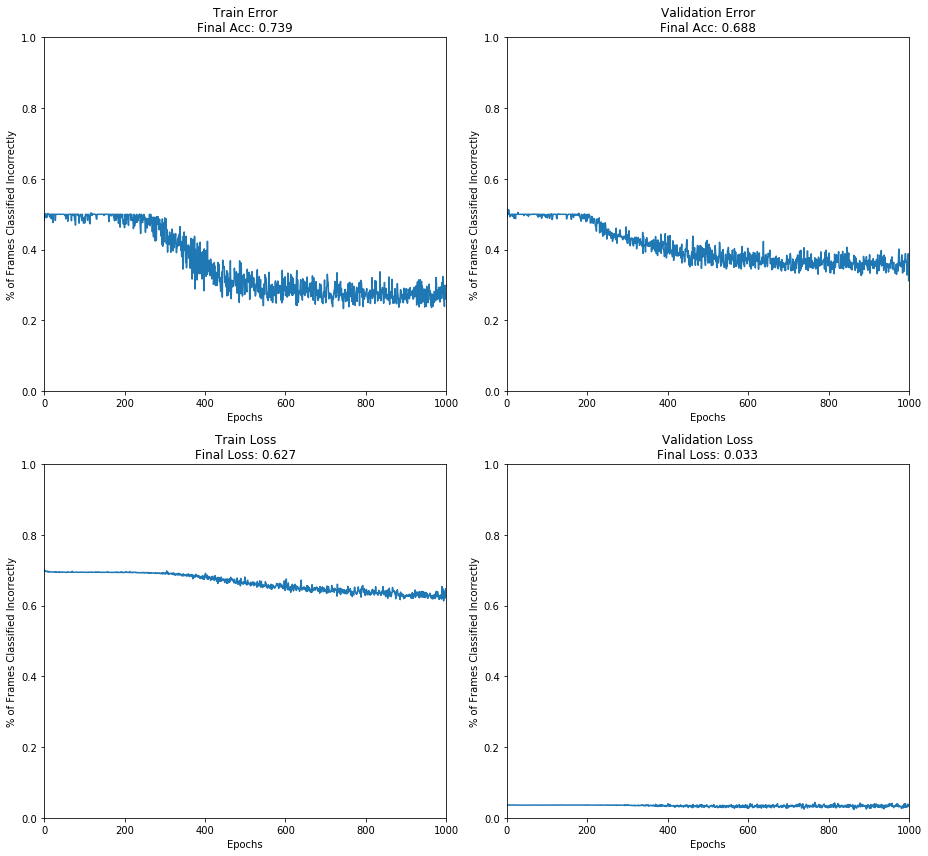

In [258]:
train_acc=0
val_acc=0
train_loss=0
val_loss=0
num_itrs=trainRes.index[-1][0]+1

for i in range(num_itrs):
    train_acc+=trainRes['train_acc'][i]/num_itrs
    val_acc+=trainRes['val_acc'][i]/num_itrs
    train_loss+=trainRes['train_loss'][i]/num_itrs
    val_loss+=trainRes['val_loss'][i]/num_itrs
    
fig,ax=plt.subplots(2,2,figsize=(13, 12))

ax[0][0].plot(1-train_acc)
ax[0][0].set_title("Train Error\nFinal Acc: "+str(np.round(train_acc.iloc[-1],3)))
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("% of Frames Classified Incorrectly")
ax[0][0].set_xlim([0,train_acc.size])
ax[0][0].set_ylim([0,1])

ax[0][1].plot(1-val_acc)
ax[0][1].set_title("Validation Error\nFinal Acc: "+str(np.round(val_acc.iloc[-1],3)))
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("% of Frames Classified Incorrectly")
ax[0][1].set_xlim([0,train_acc.size])
ax[0][1].set_ylim([0,1])

ax[1][0].plot(train_loss)
ax[1][0].set_title("Train Loss\nFinal Loss: "+str(np.round(train_loss.iloc[-1],3)))
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("% of Frames Classified Incorrectly")
ax[1][0].set_xlim([0,train_acc.size])
ax[1][0].set_ylim([0,1])

ax[1][1].plot(val_loss)
ax[1][1].set_title("Validation Loss\nFinal Loss: "+str(np.round(val_loss.iloc[-1],3)))
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("% of Frames Classified Incorrectly")
ax[1][1].set_xlim([0,train_acc.size])
ax[1][1].set_ylim([0,1])

plt.tight_layout()

In [259]:
test_acc=0
y_score=np.zeros((100,2))
y_score_curr=y_score
y_test=np.zeros((100,2))
y_test_curr=y_test
max_acc=0
opt_thresh=0

# for thresh in range(-100,100):
#     thresh=thresh/100
#     test_acc=0
for i in range(100):
    if i<50:
        y_score[i,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
        y_test[i,:]=np.vstack((np.ones(1),np.zeros(1))).T
        spk_diff=y_score[i,1]-y_score[i,0]
        if spk_diff>opt_thresh:
            test_acc+=1
    else:
        y_score[i,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
        y_test[i,:]=np.vstack((np.zeros(1),np.ones(1))).T
        spk_diff=y_score[i,1]-y_score[i,0]
        if spk_diff<opt_thresh:
            test_acc+=1
    
#     if max_acc<test_acc/100:
#         max_acc=test_acc/100
#         opt_thresh=thresh
#         y_score=y_score_curr
#         y_test=y_test_curr
        

Text(0.5, 1.0, 'm-FDA v. Difference in Classification Probability\nOverall Test Acc: 0.68\nSpearman Correlation: 0.412 \nCAE, early fusion - narrowband/broadband')

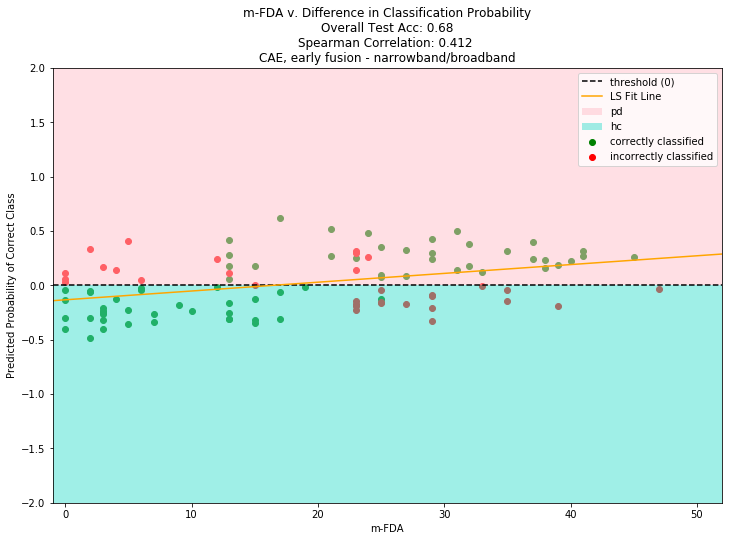

In [263]:
"""Prediction based on difference between predicted class probs."""
poly=np.polyfit(mfdas, y_score[:,0]-y_score[:,1], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(mfdas, y_score[:,0]-y_score[:,1])

plt.figure(figsize=(12,8))
correct_idx=np.concatenate((np.where((y_score[0:50,0]-y_score[0:50,1])>0)[0],np.where((y_score[50:,0]-y_score[50:,1])<0)[0]+50))
incorrect_idx=np.concatenate((np.where((y_score[0:50,0]-y_score[0:50,1])<0)[0],np.where((y_score[50:,0]-y_score[50:,1])>0)[0]+50))
plt.scatter(mfdas[correct_idx],(y_score[:,0]-y_score[:,1])[correct_idx],c='g' )
plt.scatter(mfdas[incorrect_idx],(y_score[:,0]-y_score[:,1])[incorrect_idx],c='r' )
plt.axhline(y=opt_thresh, color='black', linestyle='--',label="optimal threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(opt_thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, opt_thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(opt_thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA')
plt.ylabel('Predicted Probability of Correct Class')
plt.title('m-FDA v. Difference in Classification Probability\nOverall Test Acc: '+str(correct_idx.shape[0]/100)+'\nSpearman Correlation: '+str(np.round(cor[0],3)) +' \n'+mod+", "+rep)

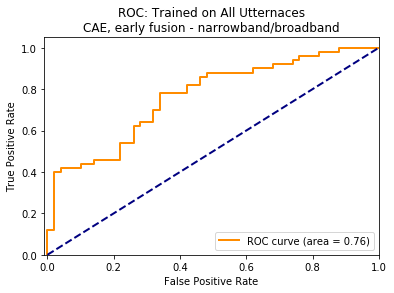

In [243]:
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]), np.array(y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Trained on All Utternaces\n'+mod+", "+rep)
plt.legend(loc="lower right")

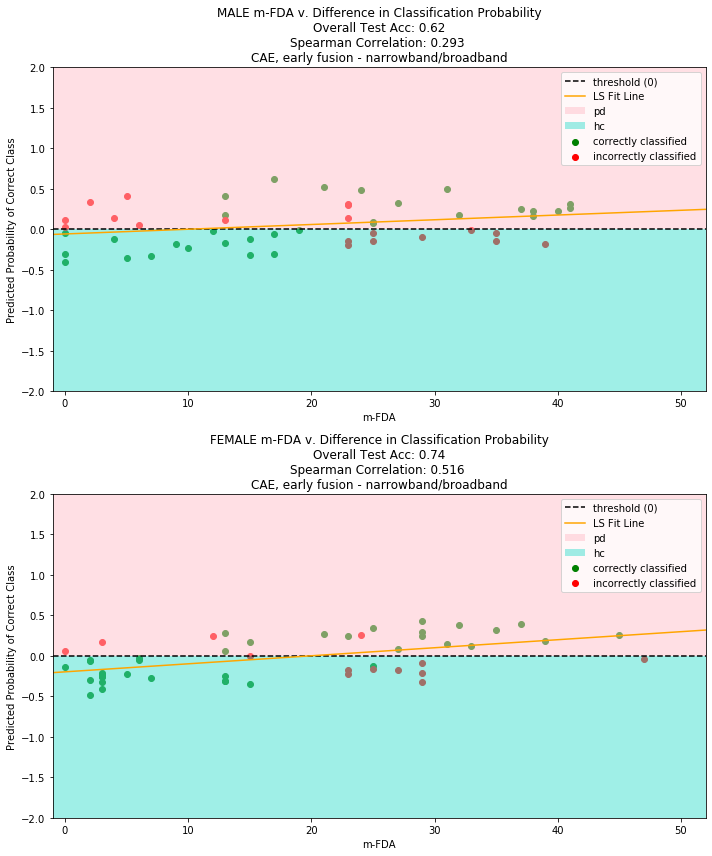

In [269]:
"""Gender based classification results (note that data used to train AEs skewed heavily male while PD data is evenly split M/F)"""
num_spks=100
mfda_path=PATH+"/pdSpanish/"
data=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
genders=data['gender'].values
mfdas=data['M-FDA'].values
m_idx=np.where(genders=='M')[0]
f_idx=np.where(genders=='F')[0]
m_mfdas=mfdas[m_idx]
f_mfdas=mfdas[f_idx]

m_test_acc=0
f_test_acc=0
m_y_score=np.zeros((50,2))
m_y_test=np.zeros((50,2))
f_y_score=np.zeros((50,2))
f_y_test=np.zeros((50,2))

m_count=0
f_count=0
for i in range(100):
    if i<50:
        if i in m_idx:
            m_y_score[m_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff>opt_thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_y_score[f_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff>opt_thresh:
                f_test_acc+=1
            f_count+=1
    else:
        if i in m_idx:
            m_y_score[m_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff<opt_thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_y_score[f_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff<opt_thresh:
                f_test_acc+=1
            f_count+=1


"""Prediction based on difference between predicted class probs."""
opt_thresh=0

itr=0
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,12))
for ax,mfdas,y_score,y_test in zip([ax1,ax2],[m_mfdas,f_mfdas],[m_y_score,f_y_score],[m_y_test,f_y_test]):
    poly=np.polyfit(mfdas, y_score[:,0]-y_score[:,1], 1)
    x_lin_reg = range(-2, 53)
    predict = np.poly1d(poly)
    cor=stats.spearmanr(mfdas, y_score[:,0]-y_score[:,1])
    
    correct_idx=np.concatenate((np.where((y_score[0:25,0]-y_score[0:25,1])>0)[0],np.where((y_score[25:,0]-y_score[25:,1])<0)[0]+25))
    incorrect_idx=np.concatenate((np.where((y_score[0:25,0]-y_score[0:25,1])<0)[0],np.where((y_score[25:,0]-y_score[25:,1])>0)[0]+25))
    ax.scatter(mfdas[correct_idx],(y_score[:,0]-y_score[:,1])[correct_idx],c='g' )
    ax.scatter(mfdas[incorrect_idx],(y_score[:,0]-y_score[:,1])[incorrect_idx],c='r' )
    ax.axhline(y=opt_thresh, color='black', linestyle='--',label="optimal threshold")
    ax.plot(x_lin_reg,predict(x_lin_reg), color='orange')
    ax.axhspan(opt_thresh, 2, color='pink', alpha=0.5, lw=0)
    ax.axhspan(-2, opt_thresh, color='turquoise', alpha=0.5, lw=0)
    ax.legend(['threshold ('+str(opt_thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
    ax.set_xlim([-1,52])
    ax.set_ylim([-2,2])
    ax.set_xlabel('m-FDA')
    ax.set_ylabel('Predicted Probability of Correct Class')
    if itr==0:
        ax.set_title('MALE m-FDA v. Difference in Classification Probability\nOverall Test Acc: '+str(correct_idx.shape[0]/50)+'\nSpearman Correlation: '+str(np.round(cor[0],3)) +' \n'+mod+", "+rep)
        itr+=1
    else:
        ax.set_title('FEMALE m-FDA v. Difference in Classification Probability\nOverall Test Acc: '+str(correct_idx.shape[0]/50)+'\nSpearman Correlation: '+str(np.round(cor[0],3)) +' \n'+mod+", "+rep)
plt.tight_layout()

In [245]:
pdIds=[0,3,5,22,31]
hcIds=[50,51,52,53,54]

testDict={rep:{spk:{num[i]:{'feats':[]} for num in zip(pdIds,hcIds)} for i,spk in enumerate(['pd','hc'])} for rep in ['broadband', 'narrowband']}



In [246]:
for rritr,tstId in enumerate(testDict[list(testDict.keys())[0]]['pd'].keys()):
    xTest=testDict['narrowband']['pd'][tstId]
    print(xTest)
    break

{'feats': []}
